# CNN-LSTM

https://towardsdatascience.com/cnn-lstm-based-models-for-multiple-parallel-input-and-multi-step-forecast-6fe2172f7668

Lets try multiple two layer 1-D convolutional heads, feeding into a single LSTM

## Load data, functions

In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std

from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pywt

In [2]:
import tensorflow.python.platform.build_info as build
print(build.build_info)

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.27.29110/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [3]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [4]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

In [5]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [6]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()

In [7]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

NameError: name 'data' is not defined

In [9]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

In [11]:
data.to_csv("C:\\Users\\conal\\Desktop\\MCM\\Practicum - Copy\\data\\all_data_5min 11-26 to 05-26.csv")

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [23]:
def generate_training_val_examples(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))

    
    return X_train, y_train, X_val, y_val, scaler



In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [26]:
def descale_y_retrun_metrics(yhat, y_val2):
    #We will use validation data that has not had outleirs limited, will be a different min/max scaler as such
    dict_indexes=[]
    dict_dfs=[]
    for j in range(0, n_steps_out):
        RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
        for i in range(0, len(inputs)):  
            pred_descaled= (scaler.inverse_transform(yhat[:,j:j+1,:].reshape(yhat.shape[0], yhat.shape[2])))[:, i:i+1]
            groud_truth_descaled= ((scaler.inverse_transform(y_val2[:,j:j+1,:].reshape(y_val2.shape[0], y_val2.shape[2]))))[:, i:i+1]
            RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
            MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
            MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
            MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
            R2 = r2_score(groud_truth_descaled, pred_descaled)
            RMSE_list.append(RMSE)
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            R2_list.append(R2)
            MSE_list.append(MSE)
        metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=inputs)
        dict_dfs.append(metrics_df)
        dict_indexes.append('Lookahead' +str(j))
    metrics_dict = dict(zip(dict_indexes, dict_dfs))
    return metrics_dict

In [27]:
def generate_training_val_examples_univariate_output(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))[:,:,:1]
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))[:,:,:1]

    
    return X_train, y_train, X_val, y_val, scaler

In [80]:
def descale_y_retrun_metrics_univariate_y(yhat, y_val2):
    #We will use validation data that has not had outleirs limited, will be a different min/max scaler as such
    dict_indexes=[]
    dict_dfs=[]
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    for j in range(0, n_steps_out):
        pred_descaled= (scaler.inverse_transform(yhat[:, j:j+1].reshape(yhat.shape[0], yhat.shape[2])))[:,:1]
        groud_truth_descaled= (scaler.inverse_transform(array([y_val2[ :, j:j+1].reshape(y_val2.shape[0])]*len(inputs)).transpose()))[:,:1]
        RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
        MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
        MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
        MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
        R2 = r2_score(groud_truth_descaled, pred_descaled)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
    metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1, (n_steps_out+1)))

 
    return metrics_df

## Multihead CNN-LSTM

In [47]:
def LSTM_model():
    input_layer = Input(shape=(n_steps_in, len(inputs))) 
    head_list = []
    
    #1 head for each input
    for i in range(0, len(inputs)):
        conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
        conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv_layer_head)
        conv_layer_flatten = Flatten()(conv_layer_head_2)
        head_list.append(conv_layer_flatten)

        
    concat_cnn = Concatenate(axis=1)(head_list)
    reshape = Reshape((head_list[0].shape[1], len(inputs)))(concat_cnn)
    lstm = LSTM(100, activation='tanh')(reshape)
    repeat = RepeatVector(n_steps_out)(lstm)
    
    
    lstm_2 = (Bidirectional(LSTM(100, activation='tanh', return_sequences=True)))(repeat)
    dropout = Dropout(0.2)(lstm_2)
    dense = Dense(len(inputs), activation='linear')(dropout)
    model = Model(inputs=input_layer, outputs=dense)
    model.compile(loss='mse', optimizer='adam')
    return model

In [50]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    

    
    
    model = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save(('multi-cnn/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)
    
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    keras.backend.clear_session()



D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 97s 764ms/step - loss: 0.3715 - val_loss: 0.0586
Epoch 2/15
107/107 [==============================] - 79s 744ms/step - loss: 0.3430 - val_loss: 0.0554
Epoch 3/15
107/107 [==============================] - 81s 761ms/step - loss: 0.3322 - val_loss: 0.0594
Epoch 4/15
107/107 [==============================] - 79s 743ms/step - loss: 0.3227 - val_loss: 0.0596
Epoch 5/15
107/107 [==============================] - 79s 743ms/step - loss: 0.3158 - val_loss: 0.0829
Epoch 6/15
107/107 [==============================] - 80s 745ms/step - loss: 0.3116 - val_loss: 0.0801
Epoch 7/15
107/107 [==============================] - 79s 741ms/step - loss: 0.3061 - val_loss: 0.1053
Epoch 8/15
107/107 [==============================] - 80s 753ms/step - loss: 0.2919 - val_loss: 0.1274
Epoch 9/15
107/107 [==============================] - 81s 754ms/step - loss: 0.2860 - val_loss: 0.0654
Epoch 10/15
107/107 [==============================] - 80s 750ms/step - l

INFO:tensorflow:Assets written to: multi-cnn/Month0\assets


INFO:tensorflow:Assets written to: multi-cnn/Month0\assets


46/46 [==============================] - 14s 265ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
 41/114 [=========>....................] - ETA: 46s - loss: 0.8899

KeyboardInterrupt: 

In [51]:
#ran for 1 month; trainign metrics a lot better than single ehaded model
training_metrics_dicts

[        RMSE          MSE        MAE      MAPE        R2
 1  30.282439   917.026141  12.803147  0.168975  0.628543
 2  31.027364   962.697319  13.749716  0.173957  0.610056
 3  34.222115  1171.153148  14.517134  0.179951  0.525611
 4  35.376823  1251.519641  15.022221  0.189728  0.492980
 5  38.475730  1480.381774  16.556913  0.219675  0.400270]

In [52]:
valdiation_metrics_dicts

[        RMSE         MSE        MAE      MAPE        R2
 1  20.308888  412.450940  12.264873  0.177514  0.278444
 2  22.667825  513.830293  13.509438  0.191795  0.100826
 3  24.253776  588.245652  14.179671  0.200525 -0.029340
 4  25.597804  655.247553  14.717012  0.213197 -0.145534
 5  25.311592  640.676711  15.872499  0.240682 -0.119900]

### Lets visualize the forcasts

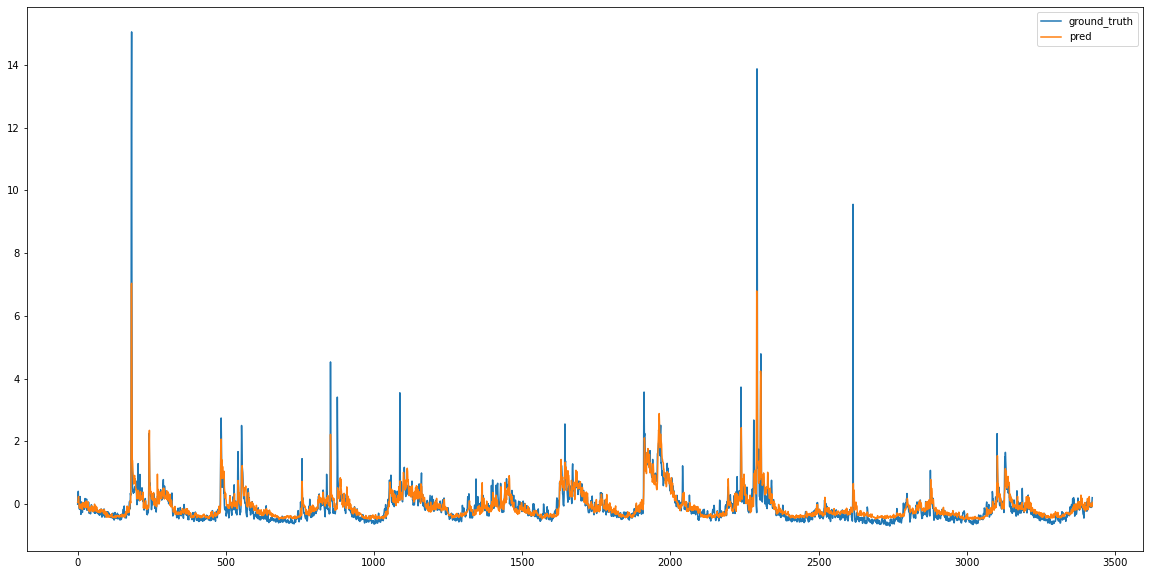

In [85]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_train[:,:1,:1].flatten(),label='ground_truth')
plt.plot(yhat_train[:,:1,:1].flatten(), label='pred')
plt.legend()

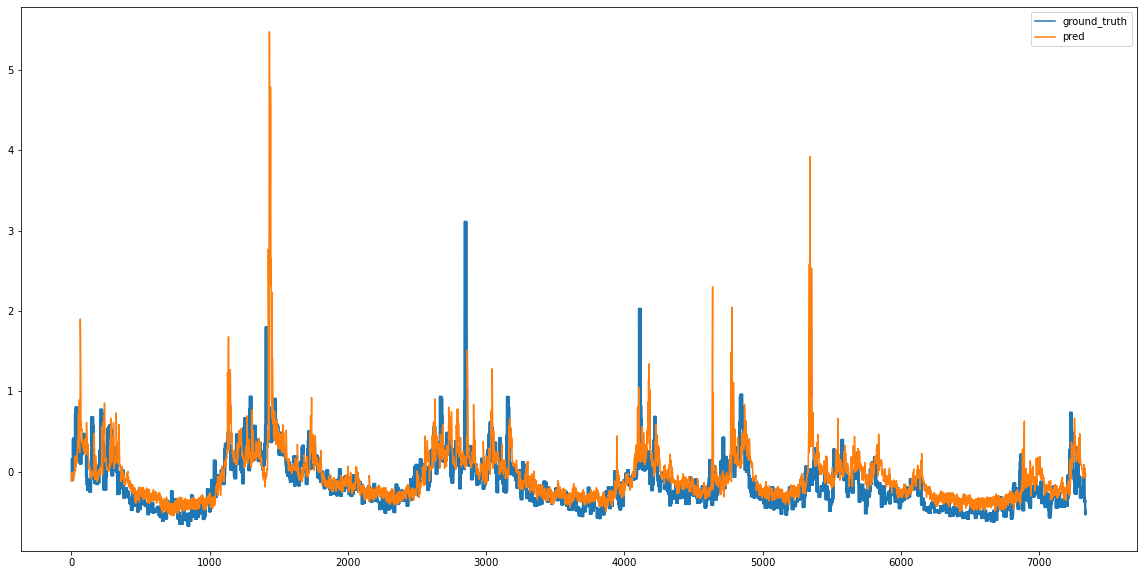

In [86]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_val[:,:5,:1].flatten(), label='ground_truth')
plt.plot(yhat_val[:,:5,:1].flatten(), label='pred')
plt.legend()

### Looks like changes in training and validation loss are not directly related; poor generalization

### Lets set a callback for validation loss and try again

## Multihead with callback, additional LSTM 

In [95]:
def LSTM_model():
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    input_layer = Input(shape=(n_steps_in, len(inputs))) 
    head_list = []
    for i in range(0, len(inputs)):
        conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
        conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv_layer_head)
        conv_layer_flatten = Flatten()(conv_layer_head_2)
        head_list.append(conv_layer_flatten)

    concat_cnn = Concatenate(axis=1)(head_list)
    reshape = Reshape((head_list[0].shape[1], len(inputs)))(concat_cnn)
    lstm = LSTM(100, activation='tanh')(reshape)
    repeat = RepeatVector(n_steps_out)(lstm)
    lstm_2 = (Bidirectional(LSTM(100, activation='tanh', return_sequences=True)))(repeat)
    dropout = Dropout(0.2)(lstm_2)
    dense = Dense(len(inputs), activation='linear')(dropout)
    model = Model(inputs=input_layer, outputs=dense)
    model.compile(loss='mse', optimizer='adam')
    return model, model_checkpoint_callback

In [96]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    

    
    
    model, model_checkpoint_callback = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save(('multi-cnn-callback/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)
    
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    keras.backend.clear_session()

pd.DataFrame(train_loss_list).to_csv('multi-cnn-callback/train_loss')
pd.DataFrame(val_loss_list).to_csv('multi-cnn-callback/val_loss')

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 89s 773ms/step - loss: 0.3821 - val_loss: 0.0656
Epoch 2/15
107/107 [==============================] - 79s 743ms/step - loss: 0.3523 - val_loss: 0.0605
Epoch 3/15
107/107 [==============================] - 79s 742ms/step - loss: 0.3403 - val_loss: 0.0710
Epoch 4/15
107/107 [==============================] - 79s 743ms/step - loss: 0.3320 - val_loss: 0.0625
Epoch 5/15
107/107 [==============================] - 80s 746ms/step - loss: 0.3200 - val_loss: 0.0565
Epoch 6/15
107/107 [==============================] - 79s 743ms/step - loss: 0.3171 - val_loss: 0.0628
Epoch 7/15
107/107 [==============================] - 79s 742ms/step - loss: 0.3028 - val_loss: 0.0665
Epoch 8/15
107/107 [==============================] - 80s 744ms/step - loss: 0.2966 - val_loss: 0.0568
Epoch 9/15
107/107 [==============================] - 80s 745ms/step - loss: 0.2919 - val_loss: 0.0958
Epoch 10/15
107/107 [==============================] - 81s 756ms/step - l

INFO:tensorflow:Assets written to: multi-cnn-callback/Month0\assets


INFO:tensorflow:Assets written to: multi-cnn-callback/Month0\assets


46/46 [==============================] - 14s 271ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
114/114 [==============================] - 96s 780ms/step - loss: 0.7081 - val_loss: 0.4566
Epoch 2/15
114/114 [==============================] - 86s 758ms/step - loss: 0.6069 - val_loss: 0.4599
Epoch 3/15
114/114 [==============================] - 89s 782ms/step - loss: 0.5740 - val_loss: 0.4126
Epoch 4/15
114/114 [==============================] - 89s 781ms/step - loss: 0.5525 - val_loss: 0.3932
Epoch 5/15
114/114 [==============================] - 88s 774ms/step - loss: 0.5360 - val_loss: 0.3778
Epoch 6/15
114/114 [==============================] - 87s 765ms/step - loss: 0.5204 - val_loss: 0.4305
Epoch 7/15
114/114 [==============================] - 89s 781ms/step - loss: 0.5075 - val_loss: 0.4214
Epoch 8/15
114/114 [==============================] - 89s 781ms/step - loss: 0.5022 - val_loss: 0.4185
Epoch 9/15
114/114 [==============================] - 88s 777ms/step - loss: 0.4894 - val_loss: 0.3655
Epoch 10/15
114/114 [==============================] - 87s 767ms/step - l

INFO:tensorflow:Assets written to: multi-cnn-callback/Month1\assets


INFO:tensorflow:Assets written to: multi-cnn-callback/Month1\assets


49/49 [==============================] - 14s 282ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
108/108 [==============================] - 98s 837ms/step - loss: 0.2704 - val_loss: 0.3416
Epoch 2/15
108/108 [==============================] - ETA: 0s - loss: 0.2401

KeyboardInterrupt: 

In [97]:
# ran for 2 months, getting better val metrics now with callbak
training_metrics_dicts

[        RMSE          MSE        MAE      MAPE        R2
 1  36.604213  1339.868393  15.801993  0.211674  0.457263
 2  33.974381  1154.258538  15.295360  0.199249  0.532464
 3  31.769061  1009.273263  15.109420  0.195937  0.591182
 4  31.419676   987.196036  15.389018  0.201674  0.600064
 5  34.988480  1224.193705  16.612373  0.222354  0.504057,
         RMSE          MSE        MAE      MAPE        R2
 1  42.436909  1800.891216  21.378994  0.127703  0.628483
 2  46.556020  2167.462963  23.581183  0.141963  0.552863
 3  48.458841  2348.259303  24.801119  0.150095  0.515565
 4  49.742506  2474.316855  25.463553  0.153705  0.489578
 5  50.828820  2583.568941  26.259849  0.156539  0.467041]

In [98]:
valdiation_metrics_dicts

[        RMSE         MSE        MAE      MAPE        R2
 1  20.757631  430.879247  15.547063  0.238817  0.246205
 2  21.773588  474.089114  16.041040  0.238171  0.170371
 3  22.300900  497.330132  16.283024  0.238585  0.129748
 4  22.401763  501.839005  16.337155  0.241419  0.122662
 5  22.637789  512.469497  16.793806  0.255966  0.104206,
         RMSE          MSE        MAE      MAPE        R2
 1  44.175677  1951.490398  26.068342  0.156042  0.488333
 2  46.898186  2199.439845  26.884084  0.161275  0.423391
 3  47.870592  2291.593582  27.760969  0.168406  0.399425
 4  48.392600  2341.843715  28.360850  0.172671  0.386110
 5  49.166213  2417.316517  29.145481  0.177670  0.366267]

In [107]:
month=1
start_date=Start_dates[month]
end_date=end_dates[month]
X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


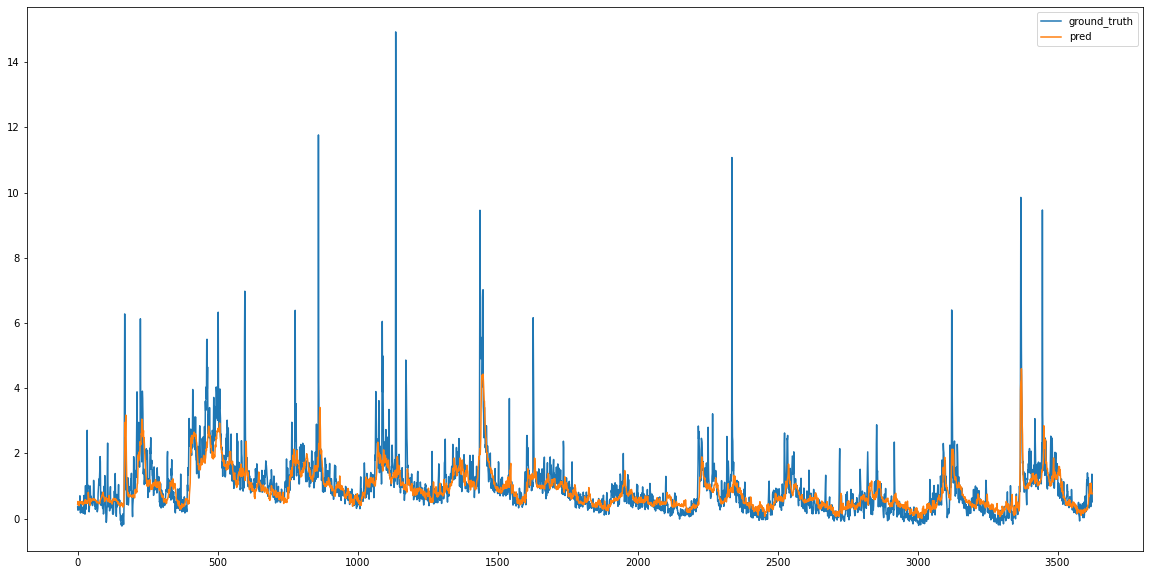

In [115]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_train[:,4:5,:1].flatten(),label='ground_truth')
plt.plot(yhat_train[:,4:5,:1].flatten(), label='pred')
plt.legend()

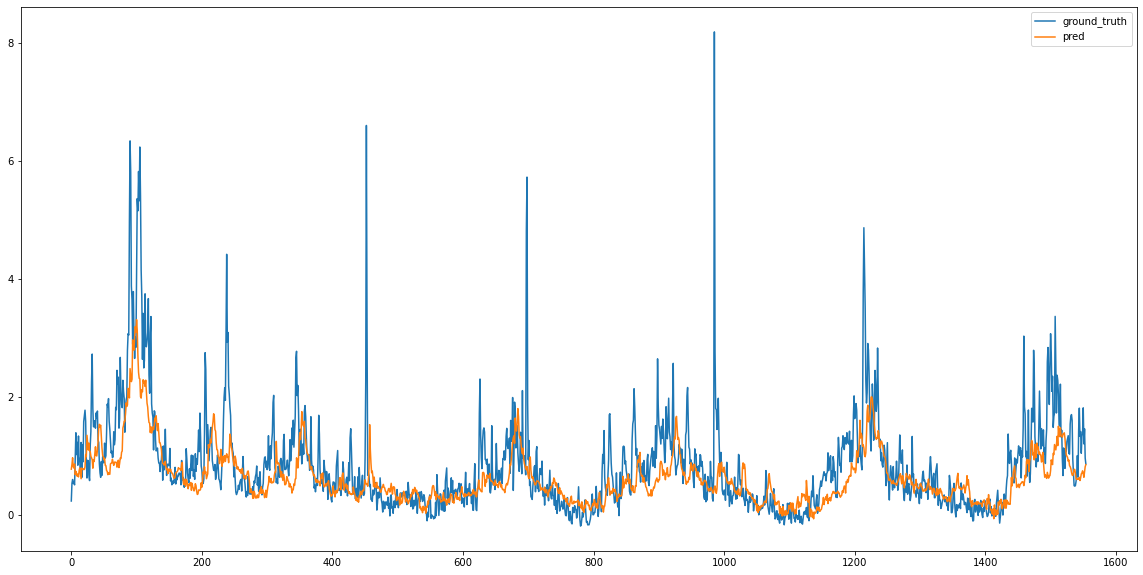

In [116]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_val[:,4:5,:1].flatten(), label='ground_truth')
plt.plot(yhat_val[:,4:5,:1].flatten(), label='pred')
plt.legend()